# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using a qutrit to represent the bosonic dof at r=2.

The possible quantum numbers at each site are:
- r=0:
  - (ni, no) = (0, 0), (0, 1), (1, 1)
  - nl = 0
- r=1:
  - (ni, no) = all combinations
  - nl = 0, 1
- r=2: all combinations
- r=3: (ni, no, nl) = (0, 0, 1), (0, 1, 0), (1, 0, 1), (1, 1, 1)

Considering first-order Trotter for the moment.

In [1]:
import os
import sys
sys.path.append('/home/iiyama/src/qutrit-experiments')
sys.path.append('/home/iiyama/src/lsh-qudit')
from copy import deepcopy
from collections import defaultdict
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile, qpy
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_ibm_runtime.fake_provider import FakeKawasaki
from qutrit_experiments.gates import (X12Gate, P1Gate, P2Gate, RZ12Gate, QGate, XplusGate,
                                      XminusGate, QubitQutritCRxMinusPiGate, QubitQutritCRxPlusPiGate)
from lsh_qudit.diag_terms import diag_propagator_circuit, get_all_orderings, get_opt3_pm
from lsh_qudit.validator import circuit_unitary, validate_circuit
from lsh_qudit.utils import remove_idle_wires, op_matrix

In [2]:
circuit_repo_path = '/data/iiyama/lsh-qudit/circuits'

## Model parameters

In [3]:
num_sites = 4
mass_mu = 1.
interaction_x = 1.

time_step = Parameter('$\Delta$t')
dt = 0.73 # A random not-so-small number for numerical validation

backend = FakeKawasaki()
# Initial mapping of occupation numbers to physical qubits (i and o get swapped)
#                l2
#                a0
# o0-i0-i1-o1-o2-i2-i3-o3
#          l1          l3
physical_fermion_i = [64, 65, 68, 69]
physical_fermion_o = [63, 66, 67, 70]
physical_boson = [73, 49, 74]
physical_ancilla = [55]
fix_right_boundary = False

In [4]:
fermion_i = QuantumRegister(num_sites, name='fermion_i')
fermion_o = QuantumRegister(num_sites, name='fermion_o')
boson = QuantumRegister(num_sites, name='boson')
ancilla = QuantumRegister(num_sites - 3, name='ancilla')

bulk_fermion_i = fermion_i[2:num_sites - 1]
bulk_fermion_o = fermion_o[2:num_sites - 1]
bulk_boson = boson[2:num_sites - 1]

initial_qubit_mapping = (dict(zip(fermion_i, physical_fermion_i))
                         | dict(zip(fermion_o, physical_fermion_o))
                         | dict(zip(boson, physical_boson))
                         | dict(zip(ancilla, physical_ancilla)))

## Constants

In [5]:
pi = np.pi
sqrt2 = np.sqrt(2.)
sqrt3 = np.sqrt(3.)

paulii = SparsePauliOp('I')
paulix = SparsePauliOp('X')
pauliy = SparsePauliOp('Y')
pauliz = SparsePauliOp('Z')
hadamard = (paulix + pauliz) / sqrt2
p0 = SparsePauliOp(['I', 'Z'], [0.5, 0.5])
p1 = SparsePauliOp(['I', 'Z'], [0.5, -0.5])
sigmaplus = (paulix + 1.j * pauliy) * 0.5  # |0><1|
sigmaminus = (paulix - 1.j * pauliy) * 0.5  # |0><1|

In [6]:
cyc_incr = np.zeros((3, 3), dtype=np.complex128)
cyc_incr[[0, 1, 2], [2, 0, 1]] = 1.
incr = cyc_incr @ np.diagflat([1., 1., 0.])
cincr = np.zeros((6, 6), dtype=np.complex128)
cincr[:3, :3] = np.eye(3, dtype=np.complex128)
cincr[3:, 3:] = incr
ocincr = np.zeros((6, 6), dtype=np.complex128)
ocincr[:3, :3] = incr
ocincr[3:, 3:] = np.eye(3, dtype=np.complex128)

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{2r}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{2r+1}\,
\end{align*}
$$

##### Circuit

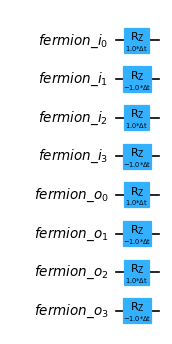

In [7]:
mass_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)
for isite in range(num_sites):
    mass_circuit.rz(((-1) ** isite) * mass_mu * time_step, fermion_i[isite])
    mass_circuit.rz(((-1) ** isite) * mass_mu * time_step, fermion_o[isite])

remove_idle_wires(mass_circuit).draw('mpl', scale=0.6)

#### Validation

In [8]:
reduced = remove_idle_wires(mass_circuit.assign_parameters({time_step: dt}), flatten=True)
nq = len(reduced.qubits)

paulis = ['I' * (nq - iq - 1) + 'Z' + 'I' * iq for iq in range(nq)]
coeffs = (1. - 2. * (np.arange(nq) % 2)) * mass_mu / 2. * dt
hmat = SparsePauliOp(paulis, coeffs).to_matrix()
validate_circuit(reduced, hmat)

True

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)}$

#### Circuit

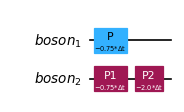

In [9]:
ele12_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)
# r=1: nl=0 or 1
ele12_circuit.p(-0.75 * time_step, boson[1])
# Bulk
for qubit in bulk_boson:
    ele12_circuit.append(P1Gate(-0.75 * time_step), [qubit])
    ele12_circuit.append(P2Gate(-2. * time_step), [qubit])

remove_idle_wires(ele12_circuit).draw('mpl', scale=0.6)

#### Validation

In [10]:
reduced = remove_idle_wires(ele12_circuit.assign_parameters({time_step: dt}), flatten=True)
nq = len(reduced.qubits)
shape = (3,) * len(bulk_boson) + (2,)
qutrits = tuple(range(1, nq))

nl = np.arange(2)
hmat = op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, 0)
nl = np.arange(3)
for iq in range(1, nq):
    hmat += op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, iq)
hmat *= dt

validate_circuit(reduced, hmat, qutrits=qutrits)

True

### $H_E^{(3)}$

In [11]:
ele3_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)

#### Fermionic term circuit

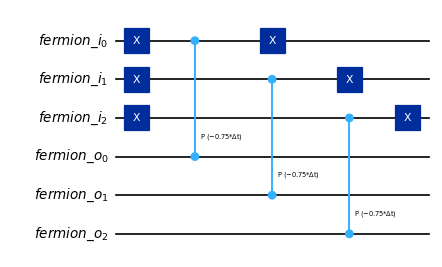

In [12]:
# 3/4 * (1 - n_i) * n_o
ele3_f_circuit = ele3_circuit.copy_empty_like()
ele3_f_circuit.x(fermion_i[:-1])
ele3_f_circuit.cp(-0.75 * time_step, fermion_i[:-1], fermion_o[:-1])
ele3_f_circuit.x(fermion_i[:-1])
ele3_circuit.compose(ele3_f_circuit, inplace=True)
remove_idle_wires(ele3_f_circuit).draw('mpl', scale=0.6)

#### Fermionic term validation

In [13]:
reduced = remove_idle_wires(ele3_f_circuit.assign_parameters({time_step: dt}), flatten=True)
nq = len(reduced.qubits)

shape = (2,) * nq
diag = np.array([0., 0., 0.75, 0.])
hmat = np.zeros((2 ** nq, 2 ** nq), dtype=np.complex128)
for iq in range(nq // 2):
    hmat += op_matrix(np.diagflat(diag), shape, (nq // 2 + iq, iq))
hmat *= dt

validate_circuit(reduced, hmat, diagonal=True)

True

#### Bosonic $r=1$ circuit

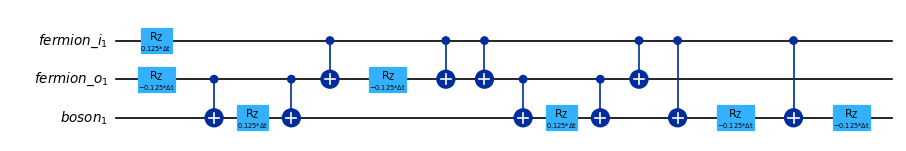

In [14]:
# 1/2 * n_l * n_o * (1 - n_i)
#  r=1
op = p1.tensor(p1).tensor(p0).simplify() * 0.5 * time_step
qubits = [fermion_i[1], fermion_o[1], boson[1]]

path = os.path.join(circuit_repo_path, 'ele3_r1.qpy')
if os.path.exists(path):
    with open(path, 'rb') as source:
        circ = qpy.load(source)[0]
    circ.assign_parameters({circ.parameters[0]: time_step}, inplace=True)
else:
    circ = diag_propagator_circuit(op, backend, [initial_qubit_mapping[q] for q in qubits])
    with open(path, 'wb') as out:
        qpy.dump(circ, out)

ele3_r1_circuit = ele3_circuit.copy_empty_like()
ele3_r1_circuit.compose(circ, qubits=qubits, inplace=True)
ele3_circuit.compose(ele3_r1_circuit, inplace=True)

remove_idle_wires(ele3_r1_circuit).draw('mpl', scale=0.6)

#### Bosonic $r=1$ validation

In [15]:
test_circ = remove_idle_wires(ele3_r1_circuit.assign_parameters({time_step: dt}), flatten=True)

hmat = op.assign_parameters({time_step: dt}).to_matrix()

validate_circuit(test_circ, hmat, diagonal=True)

True

#### Bosonic $2 \leq r \leq L-2$ circuit

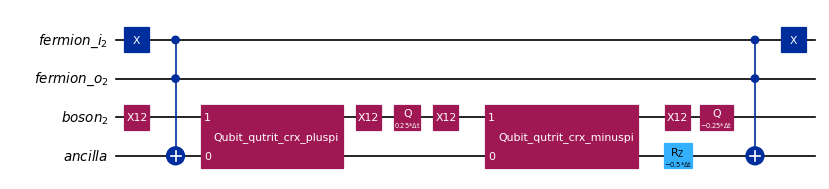

In [16]:
# 1/2 * n_l * n_o * (1 - n_i)
#  Bulk boson
#   Strategy: CCX on an ancilla, then CQ*Rz from ancilla to qutrit. CQ can be implemented with
#     CX02 - Q(φ/2) - CX02 - Q(-φ/2)
#   and CX02 is
#     X12 - CX01 - X12
ele3_bulk_circuit = ele3_circuit.copy_empty_like()
ele3_bulk_circuit.x(bulk_fermion_i)
ele3_bulk_circuit.ccx(bulk_fermion_i, bulk_fermion_o, ancilla)
for qubit, anc in zip(bulk_boson, ancilla):
    ele3_bulk_circuit.append(X12Gate(), [qubit])
    ele3_bulk_circuit.append(QubitQutritCRxPlusPiGate(), [anc, qubit])
    ele3_bulk_circuit.append(X12Gate(), [qubit])
    ele3_bulk_circuit.append(QGate(0.25 * time_step), [qubit])
    ele3_bulk_circuit.append(X12Gate(), [qubit])
    ele3_bulk_circuit.append(QubitQutritCRxMinusPiGate(), [anc, qubit])
    ele3_bulk_circuit.append(X12Gate(), [qubit])
    ele3_bulk_circuit.append(QGate(-0.25 * time_step), [qubit])
    ele3_bulk_circuit.rz(-0.5 * time_step, anc)
ele3_bulk_circuit.ccx(bulk_fermion_i, bulk_fermion_o, ancilla)
ele3_bulk_circuit.x(bulk_fermion_i)
ele3_circuit.compose(ele3_bulk_circuit, inplace=True)

remove_idle_wires(ele3_bulk_circuit).draw('mpl', scale=0.6)

#### Bosonic $2 \leq r \leq L-2$ validation

In [17]:
test_circ = remove_idle_wires(ele3_bulk_circuit.assign_parameters({time_step: dt}), flatten=True)
nbulk = num_sites - 3
nq = test_circ.num_qubits

diag = np.zeros((12,) * nbulk)
for isite in range(nbulk):
    diag = np.moveaxis(diag, isite, 0)
    diag[6] += 0.5
    diag[10] += 1.
    diag = np.moveaxis(diag, 0, isite)
hmat = np.diagflat(diag)
hmat *= dt

qutrits = tuple(range(2 * nbulk, 3 * nbulk))
ancillae = tuple(range(3 * nbulk, nq))
validate_circuit(test_circ, hmat, qutrits=qutrits, ancillae=ancillae, diagonal=True)

True

## $H_I$

### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} \ket{1}\bra{0}_{i(r+1)} Z_{o(r)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} \ket{0}\bra{1}_{i(r+1)} Z_{o(r)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


In [18]:
shape = (3, 3, 2, 2, 2, 2) # l(r+1), l(r), o(r+1), o(r), i(r+1), i(r)
diag_fn = np.sqrt((np.arange(3)[:, None, None] + np.arange(1, 3)[None, None, :])
                  / (np.arange(3)[:, None, None] + np.arange(1, 3)[None, :, None]))
hi1_mat = op_matrix(np.diagflat(diag_fn), shape, (4, 3, 2))
hi1_mat = op_matrix(cincr, shape, (3, 5)) @ hi1_mat
hi1_mat = op_matrix(ocincr, shape, (2, 4)) @ hi1_mat
hi1_mat = op_matrix(sigmaminus, shape, 1) @ hi1_mat
hi1_mat = op_matrix(pauliz, shape, 2) @ hi1_mat
hi1_mat = op_matrix(sigmaplus, shape, 0) @ hi1_mat
hi1_mat += hi1_mat.conjugate().T
hi1_mat *= interaction_x

hi1_tensor = hi1_mat.reshape(shape + shape)
hi1_columns = np.moveaxis(hi1_tensor.reshape((-1,) + hi1_tensor.shape[-6:]), 0, -1)

#### $H_I^{(1)}(r=0)$

The left boundary condition $v_{-1,0}=0$ restricts the occupation numbers at $r=0$ to $(n_l(0), n_o(0), n_i(0)) = (0, 0, 0), (0, 1, 1)$, and $(0, 1, 0)$.
The first two have $v_{0,1}=0$ while the last has $v_{0,1}=1$. The AGL-satisfying occupation number combinations are therefore
|$(n_l(0), n_o(0), n_i(0))$|$(n_l(1), n_o(1), n_i(1))$|
|------------------|------------------|
|(0, 0, 0) or (0, 1, 1)|(0, 0, 0) (0, 1, 0) (0, 1, 1)|
|(0, 1, 0)|(1, 0, 0) (1, 1, 0) (0, 0, 1) (1, 1, 1)|

$H_I^{(1)+}(0)$ annihilates all quantum number combinations except for
- (1, 1, 0) (0, 0, 0)
- (1, 1, 0) (0, 1, 0)

For these combinations, the diagonal function is
$$
\mathcal{D}\left(n_l(0), n_o(0), n_o(1)\right) = \sqrt{\frac{0 + 1 + 1}{0 + 1 + n_o(1)}} = \sqrt{2} \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)}.
$$
Because $n_{o}(0)$ is identically 1, $n_o(0)$-controlled incrementer and $Z_{o(0)}$ can be replaced by identity and $-1$, respectively. Incrementer for $l(1)$ is replaced by $\ket{1}\bra{0}$. Fully simplified form is therefore
$$
\begin{split}
H_I^{(1)+}(r) \big|_{\mathrm{BC,AGL}} & = -x \ket{0}\bra{1}_{i(0)} \ket{1}\bra{0}_{i(1)} \left[ \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} \ket{1}\bra{0}_{l(1)} \right] \left[ \sqrt{2} \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} \right] \\
& = -x \ket{0}\bra{1}_{i(0)} \ket{1}\bra{0}_{i(1)} \left[ \sqrt{2} \ket{0}\bra{0}_{o(1)} I_{l(1)} + \ket{1}\bra{1}_{o(1)} \ket{1}\bra{0}_{l(1)} \right].
\end{split}
$$

$H_I^{(1)-}(0)$ annihilates everything except for
- (0, 0, 0) (1, 1, 0)
- (0, 1, 0) (1, 0, 0)
- (0, 1, 0) (1, 1, 1)

After the controlled decrementation, the diagonal function will be evaluated on the same set of states as above. Other simplifications on $H_I^{(1)+}(0)$ also apply to this term, resulting in
$$
H_I^{(1)-}(r) \big|_{\mathrm{BC,AGL}} = -x \ket{1}\bra{0}_{i(0)} \ket{0}\bra{1}_{i(1)} \left[ \sqrt{2} \ket{0}\bra{0}_{o(1)} I_{l(1)} + \ket{1}\bra{1}_{o(1)} \ket{0}\bra{1}_{l(1)} \right],
$$
which is consistently the Hermitian conjugate of the simplified first term.

The diagonalizing unitary for this Hamiltonian is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(0) = H_{i(1)} \left[\ket{0}\bra{0}_{i(1)} + \ket{1}\bra{1}_{i(1)} X_{i(0)} (X_{l(1)})^{n_o(1)} \right].
$$
and the diagonalized Hamiltonian is
$$
\begin{split}
G^{(1)}(0) & = \mathcal{U}_{\mathrm{SVD}}^{(1)}(0) H_I^{(1)}(0) \mathcal{U}_{\mathrm{SVD}}^{(1)\dagger}(0) \\
& = -x \ket{1}\bra{1}_{i(0)} Z_{i(1)} \left[\sqrt{2} \ket{0}\bra{0}_{o(1)} I_{l(1)} + \ket{1}\bra{1}_{o(1)} \ket{0}\bra{0}_{l(1)}\right].
\end{split}
$$

In [19]:
# Validate the subspace
agl_states_r0 = (
    [0, 0, 0] * 2 + [1, 1, 0, 1],  # l1
    [0] * 10,  # l0
    [0, 1, 1] * 2 + [0, 1, 0, 1],  # o1
    [0] * 3 + [1] * 3 + [1] * 4,  # o0
    [0, 0, 1] * 2 + [0, 0, 1, 1],  # i1
    [0] * 3 + [1] * 3 + [0] * 4  # i0
)

# Flagging states that are not annihilated
mask = np.logical_not(np.all(np.isclose(hi1_columns[agl_states_r0], 0.), axis=-1))
np.transpose(agl_states_r0)[mask]

array([[0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 0]])

In [20]:
hi1r0_circuit = QuantumCircuit(fermion_i, fermion_o, boson)

##### $\mathcal{U}_{\mathrm{SVD}}^{(1)}(0)$

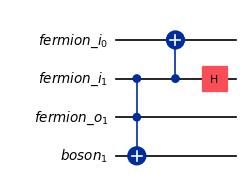

In [21]:
hi1r0_svd_circuit = hi1r0_circuit.copy_empty_like()
hi1r0_svd_circuit.ccx(fermion_i[1], fermion_o[1], boson[1])
hi1r0_svd_circuit.cx(fermion_i[1], fermion_i[0])
hi1r0_svd_circuit.h(fermion_i[1])
hi1r0_circuit.compose(hi1r0_svd_circuit, inplace=True)

remove_idle_wires(hi1r0_svd_circuit).draw('mpl', scale=0.6)

In [22]:
test_circ = remove_idle_wires(hi1r0_svd_circuit, flatten=True)

op = (paulii.tensor(p0) + paulix.tensor(p1)).tensor(p1).tensor(paulix)
op += paulii.tensor(paulii).tensor(p0).tensor(paulii)
op = paulii.tensor(paulii).tensor(hadamard).tensor(paulii) @ op
umat = op.to_matrix()

validate_circuit(test_circ, umat, exponentiate=False, diagonal=False)

True

##### $\exp\left(-i \Delta t D^{(1)}(0) \right)$

$$
\begin{split}
D^{(1)}(0) & = \mathcal{U}_{\mathrm{SVD}}^{(1)}(0) H_I^{(1)}(0) \mathcal{U}_{\mathrm{SVD}}^{(1)\dagger}(0) \\
& = -x Z_{i(1)} \ket{1}\bra{1}_{i(0)} \left(\ket{0}\bra{0}_{l(1)}\right)^{n_o(1)} \left[\sqrt{2} \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)}\right] \\
& = -x Z_{i(1)} \ket{1}\bra{1}_{i(0)} \left[\sqrt{2} \ket{0}\bra{0}_{o(1)} I_{l(1)} + \ket{1}\bra{1}_{o(1)} \ket{0}\bra{0}_{l(1)}\right].
\end{split}
$$

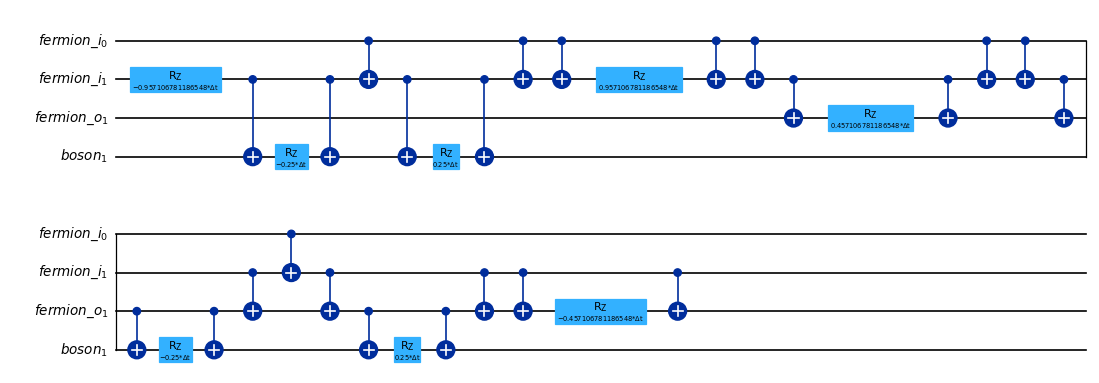

In [23]:
op = paulii.tensor(p0) * sqrt2 + p0.tensor(p1)
op = op.tensor(pauliz).tensor(p1)
op = op.simplify() * (-interaction_x * time_step)

qubits = remove_idle_wires(hi1r0_svd_circuit).qubits

path = os.path.join(circuit_repo_path, 'hi1_r0_diag.qpy')
if os.path.exists(path):
    with open(path, 'rb') as source:
        circ = qpy.load(source)[0]
    circ.assign_parameters({circ.parameters[0]: time_step}, inplace=True)
else:
    circ = diag_propagator_circuit(op, backend, [initial_qubit_mapping[q] for q in qubits])
    with open(path, 'wb') as out:
        qpy.dump(circ, out)

hi1r0_diag_circuit = hi1r0_circuit.copy_empty_like()
hi1r0_diag_circuit.compose(circ, qubits=qubits, inplace=True)
hi1r0_circuit.compose(hi1r0_diag_circuit, inplace=True)

remove_idle_wires(hi1r0_diag_circuit).draw('mpl', scale=0.6)

In [24]:
test_circ = remove_idle_wires(hi1r0_diag_circuit.assign_parameters({time_step: dt}), flatten=True)

hmat = op.assign_parameters({time_step: dt}).to_matrix()

validate_circuit(test_circ, hmat, diagonal=False)

True

##### Full hopping term validation

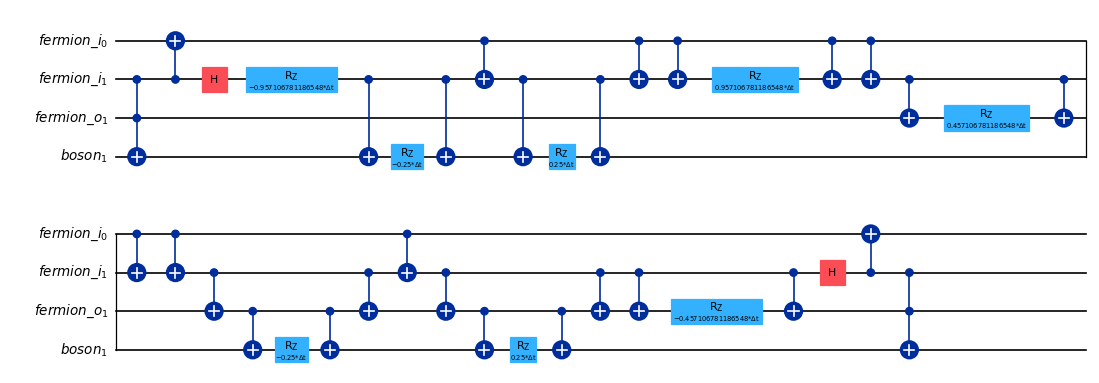

In [25]:
hi1r0_circuit.compose(hi1r0_svd_circuit.inverse(), inplace=True)

remove_idle_wires(hi1r0_circuit).draw('mpl', scale=0.6)

In [26]:
test_circ = remove_idle_wires(hi1r0_circuit.assign_parameters({time_step: dt}), flatten=True)

# Project out l0=0 and o1=1
hmat = np.moveaxis(hi1_tensor, (1, 3, 7, 9), (0, 1, 2, 3))[0, 1, 0, 1]
# Truncate l1 to 2 levels
hmat = hmat[:2, :, :, :, :2].reshape(16, 16)
hmat *= dt

validate_circuit(test_circ, hmat, diagonal=True)

True

#### $H_I^{(1)}(r=1)$

For $r=1$, the quantum number combinations are

|$(n_i(1), n_o(1), n_l(1))$|$(n_i(2), n_o(2), n_l(2))$|
|--------------------------|--------------------------|
|(0, 0, 0) (1, 0, 0) (1, 1, 0)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1, 0) (0, 0, 1) (1, 1, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|
|(0, 1, 1)|(0, 0, 2) (0, 1, 2) (1, 0, 1) (1, 1, 2)|

The first term acts nontrivially on
- (1, 0, 0) (0, 0, 0)
- (1, 0, 0) (0, 1, 0)
- (1, 1, 0) (0, 0, 0)
- (1, 1, 0) (0, 1, 0)
- (1, 1, 1) (0, 0, 1)
- (1, 1, 1) (0, 1, 1)

The diagonal function is given by
$$
\begin{split}
\mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right) = & \ket{0}\bra{0}_{l(1)} \left[ \ket{0}\bra{0}_{o(1)} + \sqrt{2}\ket{1}\bra{1}_{o(1)}\right] \left[ \ket{0}\bra{0}_{o(2)} + \frac{1}{\sqrt{2}}\ket{1}\bra{1}_{o(2)}\right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \sqrt{\frac{3}{2}} \ket{0}\bra{0}_{o(2)} + \ket{1}\bra{1}_{o(2)} \right] \\
= & \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{o(1)} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \\
\end{split}
$$

Since $n_l(1) = 0$ when $n_o(1) = 0$, $\left[\lambda^+_{l(1)} (1 - \ket{\Lambda}\bra{\Lambda})_{l(1)}\right]^{1 - n_o(1)} \to \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)}$.
Similarly, $(1 - \ket{\Lambda}\bra{\Lambda})_{l(2)} \to 1$. The simplified first term is therefore
$$
\ket{0}\bra{1}_{i(1)} Z_{o(1)} \ket{1}\bra{0}_{i(2)} \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)} \left[ \lambda^+_{l(2)}
 \right]^{n_o(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right).
$$

The second term acts on
- (0, 0, 0) (1, 1, 0)
- (0, 1, 0) (1, 0, 0)
- (0, 1, 0) (1, 1, 1)
- (0, 0, 1) (1, 0, 0)
- (0, 0, 1) (1, 1, 1)
- (0, 1, 1) (1, 0, 1)
- (0, 1, 1) (1, 1, 2)

Case $n_o(1) = 0, n_l(1) = 0$ will be annihilated by the projector. Then $n_l(2) = 1,2$ when $n_o(2) = 1$. The second term simplifies to
$$
\ket{1}\bra{0}_{i(1)} Z_{o(1)} \ket{0}\bra{1}_{i(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right)
\left[ \ket{0}\bra{1}_{l(1)} \right]^{1 - n_o(1)} 
\left[ \lambda^-_{l(2)} \right]^{n_o(2)}.
$$

The two terms are again consistently conjugates of each other.

The diagonalizing unitary is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(1) = H_{i(2)} \left[ \ket{0}\bra{0}_{i(2)}
 + \ket{1}\bra{1}_{i(2)} X_{i(1)} \left[X_{l(1)}\right]^{1 - n_o(1)} \left[\lambda^-_{l(2)}\right]^{n_o(2)} \right]
$$




and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(1) = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left[\ket{0}\bra{0}_{l(1)}\right]^{1-n_o(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \ket{0}\bra{0}_{o(1)} - \sqrt{2}\ket{1}\bra{1}_{o(1)} \right] \left[ \ket{0}\bra{0}_{o(2)} + \frac{1}{\sqrt{2}}\ket{1}\bra{1}_{o(2)} \right]
 + \ket{1}\bra{1}_{l(1)} Z_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\} \\
 = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \ket{1}\bra{1}_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
\end{split}
$$


The input states to the diagonal Hamiltonian have $(n_i(1), n_o(1), n_l(1), n_o(2), n_l(2))$ values
- (1, 0, 0, 0, 0)
- (1, 0, 0, 1, 0)
- (1, 1, 0, 0, 0)
- (1, 1, 0, 1, 0)
- (1, 1, 1, 0, 1)
- (1, 1, 1, 1, 1)

so some projectors can be replaced with identity:
$$
D^{(1)}(1) = Z_{i(2)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
$$

In [27]:
# Validate the subspace
agl_states_r1 = (
    [0, 0, 0] * 3 + [1, 1, 0, 1] * 3 + [2, 2, 1, 2],  # l2
    [0] * 3 + [0] * 3 + [0] * 3 + [0] * 4 + [1] * 4 + [1] * 4 + [1] * 4,  # l1
    [0, 1, 1] * 3 + [0, 1, 0, 1] * 3 + [0, 1, 0, 1],  # o2
    [0] * 3 + [0] * 3 + [1] * 3 + [1] * 4 + [0] * 4 + [1] * 4 + [1] * 4,  # o1
    [0, 0, 1] * 3 + [0, 0, 1, 1] * 3 + [0, 0, 1, 1],  # i2
    [0] * 3 + [1] * 3 + [1] * 3 + [0] * 4 + [0] * 4 + [1] * 4 + [0] * 4  # i1
)

mask = np.logical_not(np.all(np.isclose(hi1_columns[agl_states_r1], 0.), axis=-1))
np.transpose(agl_states_r1)[mask]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 0],
       [2, 1, 1, 1, 1, 0]])

In [52]:
hi1r1_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)

##### $\mathcal{U}_{\mathrm{SVD}}^{(1)}(1)$

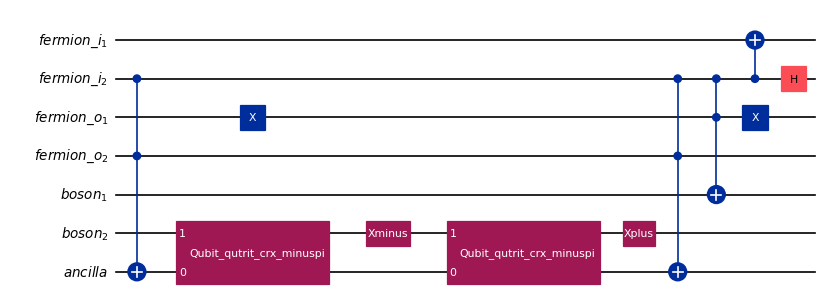

In [53]:
hi1r1_svd_circuit = hi1r1_circuit.copy_empty_like()

# Note that we deviate in geometric phase on the qutrit - will be corrected in Usvd†
hi1r1_svd_circuit.ccx(fermion_i[2], fermion_o[2], ancilla[0])
hi1r1_svd_circuit.append(QubitQutritCRxMinusPiGate(), [ancilla[0], boson[2]])
hi1r1_svd_circuit.append(XminusGate(), [boson[2]])
hi1r1_svd_circuit.append(QubitQutritCRxMinusPiGate(), [ancilla[0], boson[2]])
hi1r1_svd_circuit.append(XplusGate(), [boson[2]])
hi1r1_svd_circuit.ccx(fermion_i[2], fermion_o[2], ancilla[0])
hi1r1_svd_circuit.x(fermion_o[1])
hi1r1_svd_circuit.ccx(fermion_i[2], fermion_o[1], boson[1])
hi1r1_svd_circuit.x(fermion_o[1])
hi1r1_svd_circuit.cx(fermion_i[2], fermion_i[1])
hi1r1_svd_circuit.h(fermion_i[2])

hi1r1_circuit.compose(hi1r1_svd_circuit, inplace=True)

remove_idle_wires(hi1r1_svd_circuit).draw('mpl', scale=0.6)

$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(1) = H_{i(2)} \left[ \ket{0}\bra{0}_{i(2)}
 + \ket{1}\bra{1}_{i(2)} X_{i(1)} \left[X_{l(1)}\right]^{1 - n_o(1)} \left[\lambda^-_{l(2)}\right]^{n_o(2)} \right]
$$

In [54]:
test_circ = remove_idle_wires(hi1r1_svd_circuit, flatten=True)

shape = (3, 2, 2, 2, 2, 2)

subshape = (3, 2, 2)
subdim = np.prod(subshape)
op = np.eye(subdim, dtype=np.complex128).reshape(subshape + subshape)
op[:, 1, 1, :, 1, 1] = np.array([[0., 1.j, 0.], [0., 0., 1.j], [-1., 0., 0.]])
umat = op_matrix(op.reshape(subdim, subdim), shape, (5, 3, 1))

subshape = (2, 2, 2)
subdim = np.prod(subshape)
op = np.eye(subdim, dtype=np.complex128).reshape(subshape + subshape)
op[:, 0, 1, :, 0, 1] = paulix.to_matrix()
umat = op_matrix(op.reshape(subdim, subdim), shape, (4, 2, 1)) @ umat

subshape = (2, 2)
subdim = np.prod(subshape)
op = np.eye(subdim, dtype=np.complex128).reshape(subshape + subshape)
op[1, :, 1, :] = paulix.to_matrix()
umat = op_matrix(op.reshape(subdim, subdim), shape, (1, 0)) @ umat

umat = op_matrix(hadamard.to_matrix(), shape, (1,)) @ umat
hi1r1_svd_mat = umat

validate_circuit(test_circ, umat, qutrits=(5,), ancillae=(6,), exponentiate=False, diagonal=False)

True

##### $\exp\left(-i \Delta t D^{(1)}(1) \right)$

$$
D^{(1)}(1) = Z_{i(2)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
$$

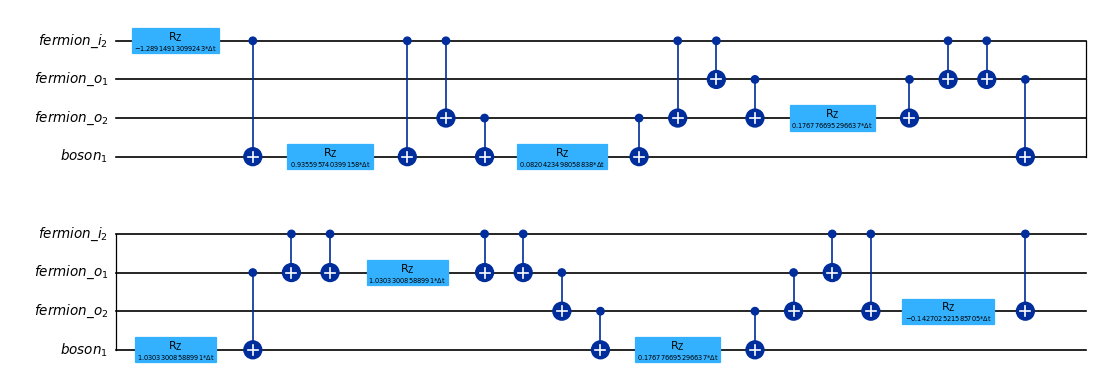

In [55]:
qubits = [fermion_i[2], fermion_o[1], fermion_o[2], boson[1]]

op = p0.tensor(paulii * (sqrt2 + 1.) + pauliz * (sqrt2 - 1.)).tensor(pauliz * (sqrt2 + 1.) - paulii * (sqrt2 - 1.)) / (4. * sqrt2)
op -= p1.tensor(paulii * (sqrt3 + sqrt2) + pauliz * (sqrt3 - sqrt2)).tensor(paulii) / (2. * sqrt2)
op = op.tensor(pauliz).simplify() * (interaction_x * time_step)

path = os.path.join(circuit_repo_path, 'hi1_r1_diag.qpy')
if os.path.exists(path):
    with open(path, 'rb') as source:
        circ = qpy.load(source)[0]
    circ.assign_parameters({circ.parameters[0]: time_step}, inplace=True)
else:
    circ = diag_propagator_circuit(op, backend, [initial_qubit_mapping[q] for q in qubits])
    with open(path, 'wb') as out:
        qpy.dump(circ, out)

hi1r1_diag_circuit = hi1r1_circuit.copy_empty_like()
hi1r1_diag_circuit.compose(circ, qubits=qubits, inplace=True)
hi1r1_circuit.compose(hi1r1_diag_circuit, inplace=True)

remove_idle_wires(hi1r1_diag_circuit, inplace=False).draw('mpl', scale=0.6)

In [56]:
test_circ = remove_idle_wires(hi1r1_diag_circuit.assign_parameters({time_step: dt}), flatten=True)

hmat = op.assign_parameters({time_step: dt}).to_matrix()
hi1r1_diag_mat = hmat

validate_circuit(test_circ, hmat, diagonal=True)

True

##### Full hopping term

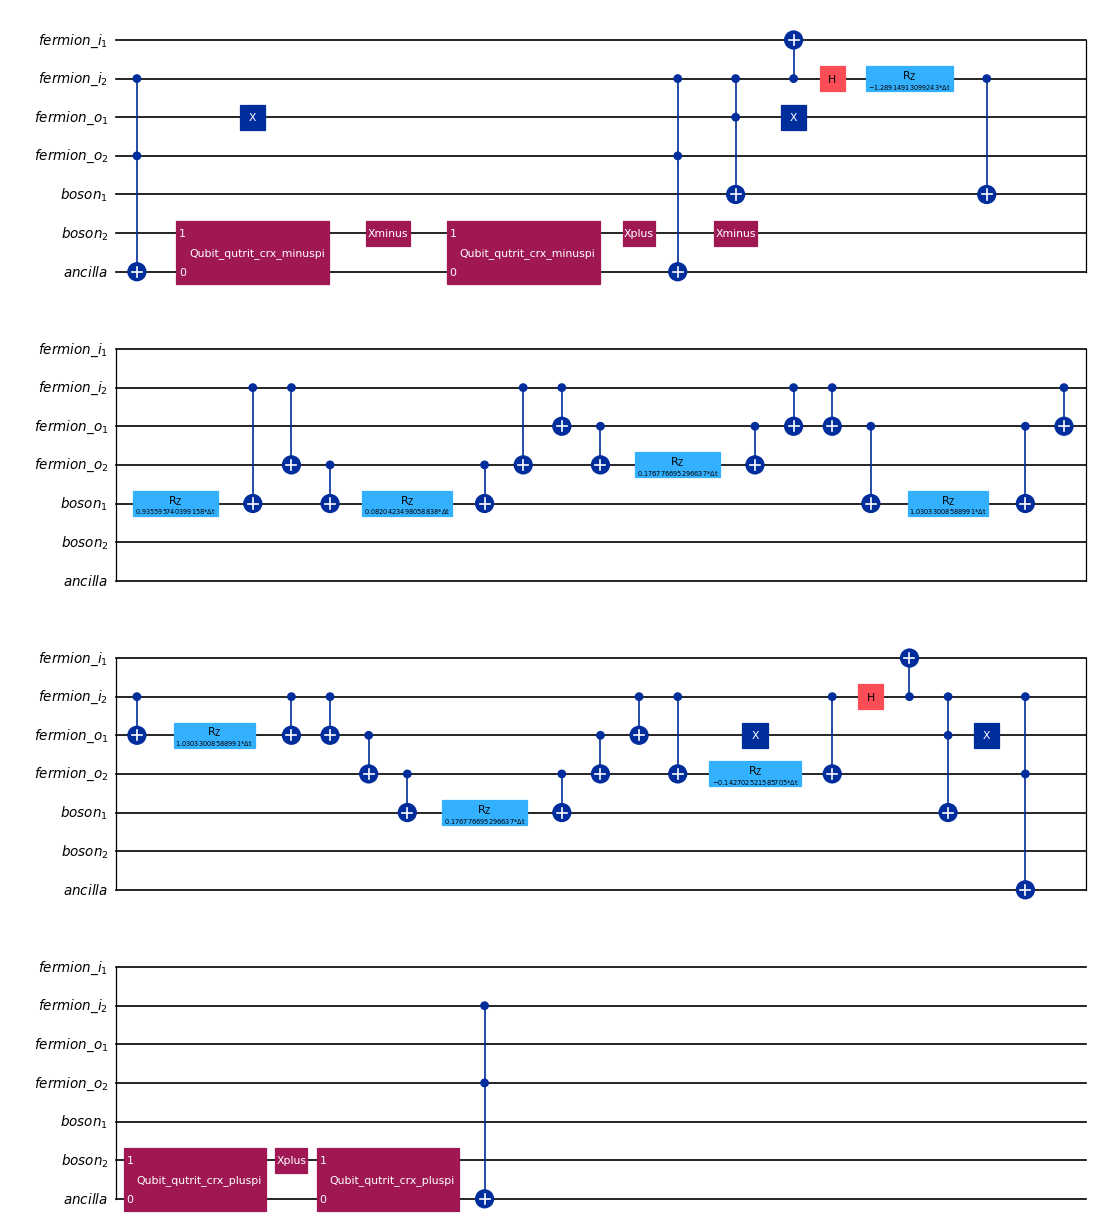

In [57]:
hi1r1_circuit.compose(hi1r1_svd_circuit.inverse(), inplace=True)

remove_idle_wires(hi1r1_circuit).draw('mpl', scale=0.6)

In [60]:
import scipy

test_circ = remove_idle_wires(hi1r1_circuit.assign_parameters({time_step: dt}), flatten=True)
unitary = circuit_unitary(test_circ, qutrits=(5,), ancillae=(6,))
diag = np.kron(np.eye(3, dtype=np.complex128), np.kron(hi1r1_diag_mat, np.eye(2, dtype=np.complex128)))

target = hi1r1_svd_mat.conjugate().T @ scipy.linalg.expm(-1.j * diag) @ hi1r1_svd_mat

In [61]:
test = np.einsum('ij,ik->jk', unitary.conjugate(), target)
np.allclose(test * test[0, 0].conjugate(), np.eye(test.shape[0]))

True

In [64]:
unitary[:, 0]

array([0.7451744+0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       -0.66686964j,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       +0.j   

In [62]:
tuple(idx[0] for idx in agl_states_r1)

(0, 0, 0, 0, 0, 0)

In [34]:
test_circ = remove_idle_wires(hi1r1_circuit.assign_parameters({time_step: dt}), flatten=True)

# Truncate l1 to 2 levels
hmat = hi1_tensor[:, :2, :, :, :, :, :, :2].reshape(96, 96)
hmat *= dt

ok, unitary, target = validate_circuit(test_circ, hmat, state_indices=agl_states_r1, qutrits=(5,), ancillae=(6,), diagonal=False, result_only=False)

In [46]:
np.nonzero(unitary[0])

(array([ 0, 19]),)

In [47]:
np.nonzero(target[0])

(array([0]),)

In [48]:
hmapped = np.moveaxis(hmat.reshape(-1, 3, 2, 2, 2, 2, 2), 0, -1)[agl_states_r1]

In [51]:
np.nonzero(hmapped)

(array([ 3,  4,  6,  7, 11, 12, 15, 16, 17, 18, 23, 24]),
 array([18, 58,  6, 46,  5, 13,  1,  9, 54, 94, 53, 61]))

In [36]:
test = np.einsum('ij,ik->jk', unitary.conjugate(), target)
test.real = np.where(np.isclose(test.real, 0.), 0., test.real)
test.imag = np.where(np.isclose(test.imag, 0.), 0., test.imag)
test

array([[0.7451744 +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       ...,
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.55528489+0.44471511j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
 

In [37]:
np.allclose(np.diagflat(np.diagonal(test)), test)

False

In [38]:
unitary = circuit_unitary(test_circ, qutrits=(5,), ancillae=(6,))
unitary_cols = np.moveaxis(unitary.reshape(-1, 3, 2, 2, 2, 2, 2), 0, -1)
final_states = unitary_cols[agl_states_r1]

array([[0.7451744+0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.       +0.j, 0.       +0.j],
       ...,
       [0.       +0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.       +0.j, 0.       +0.j, ..., 0.       +0.j,
        0.7451744+0.j, 0.       +0.j]])

In [39]:
import scipy
target = scipy.linalg.expm(-1.j * hmat)
target.real = np.where(np.isclose(target.real, 0.), 0., target.real)
target.imag = np.where(np.isclose(target.imag, 0.), 0., target.imag)
target_states = np.moveaxis(target.reshape((-1, 3, 2, 2, 2, 2, 2)), 0, -1)[agl_states_r1]

In [42]:
target_states.reshape(-1, 3, 2, 2, 2, 2, 2)[0, 0, 0, 0, 0, 0]

array([1.+0.j, 0.+0.j])

#### $H_I^{(1)}(r=2)$

For $r=2$, the quantum number combinations are

|$(n_i(2), n_o(2), n_l(2))$|$(n_i(3), n_o(3), n_l(3))$|
|--------------------------|--------------------------|
|(0, 0, 0) (1, 0, 0) (1, 1, 0)|(0, 1, 0)|
|(0, 0, 1) (0, 1, 0) (1, 0, 1) (1, 1, 1)|(0, 0, 1) (1, 1, 1)|
|(0, 0, 2) (0, 1, 1) (1, 0, 2) (1, 1, 2)|(1, 0, 1)|

The first term acts nontrivially on
- (1, 0, 0) (0, 1, 0)
- (1, 1, 0) (0, 1, 0)
- (1, 0, 1) (0, 0, 1)
- (1, 1, 1) (0, 0, 1)

The diagonal function is given by
$$
\begin{split}
\mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right) & = \ket{0}\bra{0}_{l(2)} \left[ \frac{1}{\sqrt{2}} \ket{0}\bra{0}_{o(2)} + \ket{1}\bra{1}_{o(2)}\right] + \ket{1}\bra{1}_{l(2)} \left[ \ket{0}\bra{0}_{o(2)} + \sqrt{\frac{3}{2}} \ket{1}\bra{1}_{o(2)} \right] \\
& = \ket{0}\bra{0}_{l(2)} \left[ \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{o(2)} \right] + \ket{1}\bra{1}_{l(2)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2\sqrt{2}} - \frac{\sqrt{3} - \sqrt{2}}{2\sqrt{2}} Z_{o(2)} \right]
\end{split}
$$

The projectors act identically because $n_l(2), n_l(3) \neq \Lambda$. Since $n_l(3) = 0$ when $n_o(3) = 1$, $\left[ \lambda^+_{l(3)} \right]^{n_o(3)} \to \left[\ket{1}\bra{0}_{l(3)}\right]^{n_o(3)}$. The simplified first term is therefore
$$
\ket{0}\bra{1}_{i(2)} Z_{o(2)} \ket{1}\bra{0}_{i(3)} \left[\lambda^+_{l(2)}\right]^{1 - n_o(2)} \left[ \ket{1}\bra{0}_{l(3)}
 \right]^{n_o(3)} \mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right).
$$

The second term acts on
- (0, 0, 1) (1, 1, 1)
- (0, 1, 0) (1, 1, 1)
- (0, 0, 2) (1, 0, 1)
- (0, 1, 1) (1, 0, 1)

and simplifies to
$$
\ket{1}\bra{0}_{i(2)} Z_{o(2)} \ket{0}\bra{1}_{i(3)} \mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right)
\left[ \lambda^-_{l(2)} \right]^{1 - n_o(2)} 
\left[ \ket{0}\bra{1}_{l(3)} \right]^{n_o(3)}.
$$

The diagonalizing unitary is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(2) = H_{i(3)} \left[ \ket{0}\bra{0}_{i(3)}
 + \ket{1}\bra{1}_{i(3)} X_{i(2)} \left[\lambda^-_{l(2)}\right]^{1 - n_o(2)} \left[X_{l(3)}\right]^{n_o(3)} \right]
$$


and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(2) = & Z_{i(3)} Z_{o(2)} \ket{1}\bra{1}_{i(2)} \left[\ket{0}\bra{0}_{l(3)}\right]^{n_o(3)} \mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right) \\
= & Z_{i(3)} \ket{1}\bra{1}_{i(2)} \left[\ket{0}\bra{0}_{l(3)}\right]^{n_o(3)} \left\{ \ket{0}\bra{0}_{l(2)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(2)} - \frac{\sqrt{2} - 1}{2} \right] + \ket{1}\bra{1}_{l(2)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2\sqrt{2}} Z_{o(2)} - \frac{\sqrt{3} - \sqrt{2}}{2\sqrt{2}} \right] \right\}.
\end{split}
$$

The input states to the diagonal Hamiltonian have $(n_i(2), n_o(2), n_l(2), n_o(3), n_l(3))$ values
- (1, 0, 0, 1, 0)
- (1, 1, 0, 1, 0)
- (1, 0, 1, 0, 1)
- (1, 1, 1, 0, 1)

so $(n_l(2), n_o(3), n_l(3))$ is either (0, 1, 0) or (1, 0, 1). $\ket{1}\bra{1}_{i(2)}$ and $n_o(3)$-controlled $\ket{0}\bra{0}_{l(3)}$ therefore can be replaced by identity:
$$
D^{(1)}(2) = Z_{i(3)} \left\{ \ket{0}\bra{0}_{l(2)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(2)} - \frac{\sqrt{2} - 1}{2} \right] + \ket{1}\bra{1}_{l(2)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2\sqrt{2}} Z_{o(2)} - \frac{\sqrt{3} - \sqrt{2}}{2\sqrt{2}} \right] \right\}.
$$


In [ ]:
areg = QuantumRegister(1, 'anc')
hi1r2_circuit = QuantumCircuit(fermion_i, fermion_o, boson, areg)

# U_SVD(2)
hi1r2_circuit.ccx(fermion_i[3], fermion_o[3], boson[3])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.append(XminusGate(), [boson[2]])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.append(XplusGate(), [boson[2]])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.cx(fermion_i[3], fermion_i[2])
hi1r2_circuit.h(fermion_i[3])

# exp[-itD(2)]
# D(2) = 1/4 Z_{i3} [((√2+1)Z - (√2-1)I)_{o2} (I + Z)_{l2} + ((√3/√2+1)Z - (√3/√2-1)I)_{o2} (I - Z)_{l2}]
# (2-√2-√3/√2)ZII -> (2+√2+√3/√2)ZZI -> (√2-√3/√2))ZZZ -> (√3/√2-√2)ZIZ
phi = 0.25 * time_step
hi1r2_circuit.rz(phi * (2. - sqrt2 - np.sqrt(3. / 2.)), fermion_i[3])
hi1r2_circuit.cx(fermion_i[3], fermion_o[2])
hi1r2_circuit.rz(phi * (2. + sqrt2 + np.sqrt(3. / 2.)), fermion_o[2])
hi1r2_circuit.cx(fermion_o[2], boson[2])
hi1r2_circuit.rz(phi * (sqrt2 - np.sqrt(3. / 2.)), boson[2])
hi1r2_circuit.cx(fermion_o[2], boson[2])
hi1r2_circuit.cx(fermion_i[3], fermion_o[2])
hi1r2_circuit.cx(fermion_i[3], boson[2])
hi1r2_circuit.rz(phi * (-sqrt2 + np.sqrt(3. / 2.)), boson[2])
hi1r2_circuit.cx(fermion_i[3], boson[2])

# U_SVD(2)†
hi1r2_circuit.h(fermion_i[3])
hi1r2_circuit.cx(fermion_i[3], fermion_i[2])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.append(XminusGate(), [boson[2]])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.append(XplusGate(), [boson[2]])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[3], boson[3])

### $H_I^{(2)}$

The general form of $H_I^{(2)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(2)}(r) = & \ket{1}\bra{0}_{o(r)} Z_{i(r+1)} \ket{0}\bra{1}_{o(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{n_i(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{1-n_i(r+1)} \mathcal{D}\left(n_l(r+1), n_i(r+1), n_i(r)\right) \\
& + \ket{0}\bra{1}_{o(r)} Z_{i(r+1)} \ket{1}\bra{0}_{o(r+1)} \mathcal{D}\left(n_l(r+1), n_i(r+1), n_i(r)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{n_i(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{1-n_i(r+1)}.
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


#### $H_I^{(2)}(r=0)$

For $r=0$, we set $n_l(0) = 0$ and $(n_i(0), n_o(0)) = (0, 0), (0, 1), (1, 1)$. From the AGL, quantum
numbers of $r=1$ is restricted to
|$(n_i(0), n_o(0))$|$(n_i(1), n_o(1), n_l(1))$|
|------------------|------------------|
|(0, 0) (1, 1)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|

The first term of $H_I^{(2)}(0)$ annihilates all quantum number combinations except for
- (0, 0, 0) (0, 1, 0)
- (0, 0, 0) (1, 1, 0)

For these combinations, the diagonal function is
$$
\mathcal{D}\left(n_l(1), n_i(1), n_i(0)\right) = \sqrt{\frac{0 + 1 + n_i(1)}{0 + 1 + 0}} = \ket{0}\bra{0}_{i(1)} + \sqrt{2} \ket{1}\bra{1}_{i(1)} = \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{i(1)},
$$
so the first term of the Hamiltonian simplifies to
$$
\ket{1}\bra{0}_{o(0)} Z_{i(1)} \ket{0}\bra{1}_{o(1)} \left[ \ket{0}\bra{0}_{i(1)} X_{l(1)} + \ket{1}\bra{1}_{i(1)} \right] \left[\frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{i(1)} \right].
$$

The second term annihilates everything except for
- (0, 1, 0) (0, 0, 1)
- (0, 1, 0) (1, 0, 1)

((1, 1, 0) (0, 0, 0) is annihilated by the ladder-projector combination on $r=1$.) This term simplifies
to
$$
-\ket{1}\bra{0}_{i(0)} \ket{0}\bra{1}_{i(1)} \left[\frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)}\right]
\left[ \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} X_{l(1)} \right]
$$
which is consistently the Hermitian conjugate of the simplified first term.

The diagonalizing unitary for this Hamiltonian is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(0) = H_{i(1)} \left[\ket{0}\bra{0}_{i(1)} + \ket{1}\bra{1}_{i(1)} X_{i(0)} (X_{l(1)})^{n_o(1)} \right].
$$
and the diagonalized Hamiltonian is
$$
D^{(1)}(0) = \mathcal{U}_{\mathrm{SVD}}^{(1)}(0) H_I^{(1)}(0) \mathcal{U}_{\mathrm{SVD}}^{(1)\dagger}(0) = -Z_{i(1)} \ket{1}\bra{1}_{i(0)} \left[\frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)}\right].
$$

#### $H_I^{(2)}(r=1)$

For $r=1$, the quantum number combinations are

|$(n_i(1), n_o(1), n_l(1))$|$(n_i(2), n_o(2), n_l(2))$|
|--------------------------|--------------------------|
|(0, 0, 0) (1, 0, 0) (1, 1, 0)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1, 0) (0, 0, 1) (1, 1, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|
|(0, 1, 1)|(0, 0, 2) (0, 1, 2) (1, 0, 1) (1, 1, 2)|

The first term acts nontrivially on
- (1, 0, 0) (0, 0, 0)
- (1, 0, 0) (0, 1, 0)
- (1, 1, 0) (0, 0, 0)
- (1, 1, 0) (0, 1, 0)
- (1, 1, 1) (0, 0, 1)
- (1, 1, 1) (0, 1, 1)

The diagonal function is given by
$$
\begin{split}
\mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right) = & \ket{0}\bra{0}_{l(1)} \left[ \ket{0}\bra{0}_{o(1)} + \sqrt{2}\ket{1}\bra{1}_{o(1)}\right] \left[ \ket{0}\bra{0}_{o(2)} + \frac{1}{\sqrt{2}}\ket{1}\bra{1}_{o(2)}\right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \sqrt{\frac{3}{2}} \ket{0}\bra{0}_{o(2)} + \ket{1}\bra{1}_{o(2)} \right] \\
= & \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{o(1)} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \\
\end{split}
$$

Since $n_l(1) = 0$ when $n_o(1) = 0$, $\left[\lambda^+_{l(1)} (1 - \ket{\Lambda}\bra{\Lambda})_{l(1)}\right]^{1 - n_o(1)} \to \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)}$.
Similarly, $(1 - \ket{\Lambda}\bra{\Lambda})_{l(2)} \to 1$. The simplified first term is therefore
$$
\ket{0}\bra{1}_{i(1)} Z_{o(1)} \ket{1}\bra{0}_{i(2)} \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)} \left[ \lambda^+_{l(2)}
 \right]^{n_o(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right).
$$

The second term acts on
- (0, 0, 0) (1, 1, 0)
- (0, 1, 0) (1, 0, 0)
- (0, 1, 0) (1, 1, 1)
- (0, 0, 1) (1, 0, 0)
- (0, 0, 1) (1, 1, 1)
- (0, 1, 1) (1, 0, 1)
- (0, 1, 1) (1, 1, 2)

Case $n_o(1) = 0, n_l(1) = 0$ will be annihilated by the projector. Then $n_l(2) = 1,2$ when $n_o(2) = 1$. The second term simplifies to
$$
\ket{1}\bra{0}_{i(1)} Z_{o(1)} \ket{0}\bra{1}_{i(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right)
\left[ \ket{0}\bra{1}_{l(1)} \right]^{1 - n_o(1)} 
\left[ \lambda^-_{l(2)} \right]^{n_o(2)}.
$$

The two terms are again consistently conjugates of each other.

The diagonalizing unitary is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(1) = H_{i(2)} \left[ \ket{0}\bra{0}_{i(2)}
 + \ket{1}\bra{1}_{i(2)} X_{i(1)} \left[X_{l(1)}\right]^{1 - n_o(1)} \left[\lambda^-_{l(2)}\right]^{n_o(2)} \right]
$$


and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(1) = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left[\ket{0}\bra{0}_{l(1)}\right]^{1-n_o(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 + \ket{1}\bra{1}_{l(1)} Z_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\} \\
 = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \ket{1}\bra{1}_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
\end{split}
$$


The input states to the diagonal Hamiltonian have $(n_i(1), n_o(1), n_l(1), n_o(2), n_l(2))$ values
- (1, 0, 0, 0, 0)
- (1, 0, 0, 1, 0)
- (1, 1, 0, 0, 0)
- (1, 1, 0, 1, 0)
- (1, 1, 1, 0, 1)
- (1, 1, 1, 1, 1)

so some projectors can be replaced with identity:
$$
D^{(1)}(1) = Z_{i(2)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
$$